<a href="https://colab.research.google.com/github/oObelix/DataScience/blob/master/%D0%A0%D0%B5%D0%B0%D0%BB%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F_%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D1%8F_FCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [179]:
import random
import imageio
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [180]:
tf.__version__

'2.5.0'

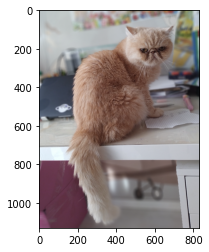

In [181]:
img = imageio.imread('keks_sm.png')
img = img[:, :, 0:3]
img = img.astype(np.float32) / 255. 
_ = plt.imshow(img)

(1130, 832, 4)
(1130, 832, 1)
1.0


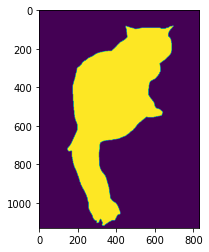

In [182]:
gt = imageio.imread("keks_sm_gt.png")
gt = gt.astype(np.float32) / 255. 
# print(gt)
print(gt.shape)
gt = np.clip(gt, 0., 1.)
gt = np.mean(gt, axis=2)[..., None]
# print(gt)
print(gt.shape)
print(gt.max())
_ = plt.imshow(gt[..., 0])

(2, 1130, 832, 3)
(2, 1130, 832, 1)


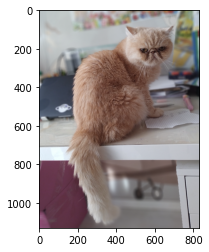

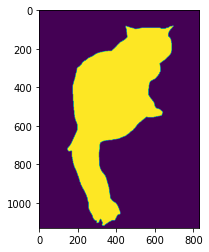

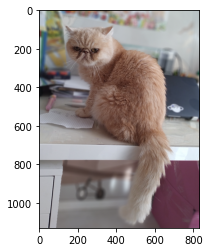

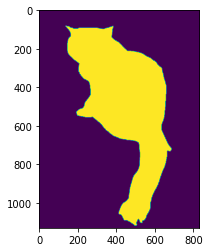

(<matplotlib.image.AxesImage at 0x7f51000f9710>, None)

In [183]:
# Создадим датасет для обучения всего из двух элеметов. 
# Нам сейчас важно сам факт и структура, а не результат обучения.

train_x = np.stack((img, img[:, ::-1, :]))
train_y = np.stack((gt, gt[:, ::-1, :]))

print(train_x.shape)
print(train_y.shape)

plt.imshow(train_x[0]), plt.show()
plt.imshow(train_y[0][..., 0]), plt.show()
plt.imshow(train_x[1]), plt.show()
plt.imshow(train_y[1][..., 0]), plt.show()

In [184]:
# Создаём модель

class Model(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.conv1 = tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu")
    self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu")
    self.conv3 = tf.keras.layers.Conv2D(128, (3, 3), padding="same", activation="relu")
    self.conv4 = tf.keras.layers.Conv2D(128, (3, 3), padding="same", activation="relu")
    self.conv5 = tf.keras.layers.Conv2D(256, (3, 3), padding="same", activation="relu")
    self.conv6 = tf.keras.layers.Conv2D(1, (3, 3), padding="same", activation=None)
    self.pool = tf.keras.layers.MaxPool2D((2, 2))

  def call(self, x):
    out = self.conv1(x)
    out = self.conv2(out)
    out = self.pool(out)
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.pool(out)
    out = self.conv5(out)
    out = self.conv6(out)
    out = tf.image.resize(out, (x.shape[1], x.shape[2]), tf.image.ResizeMethod.BILINEAR)
    out = tf.nn.sigmoid(out)
    return out

model = Model()

In [185]:
train_x.shape

(2, 1130, 832, 3)

In [186]:
train_y.shape

(2, 1130, 832, 1)

In [196]:
NUM_EPOCHS = 20
BATCH_SIZE = 2

loss = tf.keras.losses.BinaryCrossentropy()

model.compile(optimizer="adam", loss=loss, metrics=["accuracy"])
history = model.fit(train_x, train_y, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, verbose=1)

Epoch 1/20
1/1 [==============================] - 1s 816ms/step - loss: 0.1559 - accuracy: 0.9387
Epoch 2/20
1/1 [==============================] - 0s 281ms/step - loss: 1.3617 - accuracy: 0.5161
Epoch 3/20
1/1 [==============================] - 0s 283ms/step - loss: 0.4015 - accuracy: 0.7624
Epoch 4/20
1/1 [==============================] - 0s 299ms/step - loss: 0.2174 - accuracy: 0.9209
Epoch 5/20
1/1 [==============================] - 0s 296ms/step - loss: 0.4734 - accuracy: 0.7735
Epoch 6/20
1/1 [==============================] - 0s 294ms/step - loss: 0.3566 - accuracy: 0.7961
Epoch 7/20
1/1 [==============================] - 0s 289ms/step - loss: 0.2533 - accuracy: 0.8195
Epoch 8/20
1/1 [==============================] - 0s 292ms/step - loss: 0.2776 - accuracy: 0.8392
Epoch 9/20
1/1 [==============================] - 0s 290ms/step - loss: 0.3007 - accuracy: 0.8660
Epoch 10/20
1/1 [==============================] - 0s 289ms/step - loss: 0.2878 - accuracy: 0.9030
Epoch 11/20
1/1 [==

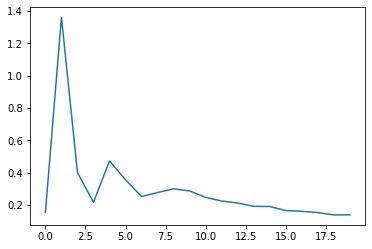

In [197]:
plt.plot(history.history['loss'])

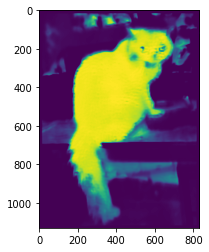

In [198]:
out = model.predict(img[None, ...])
plt.imshow(out[0, ..., 0])

(1130, 832, 3)
(1130, 832, 1)
(1130, 832, 4)


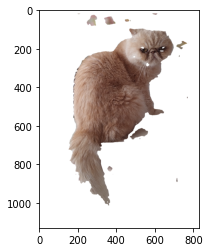

(1130, 832, 3)
(1130, 832, 1)
(1130, 832, 4)


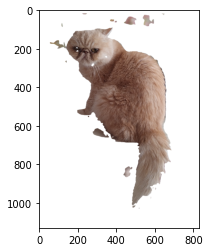

In [235]:
for sample in train_x:
    out = model.predict(sample[None, ...])
    alpha = (out[0, ..., 0]>0.5).astype(np.float32)
    alpha = alpha[..., None]
    # print(sample.shape)
    # print(alpha.shape)
    img_alpha = np.append(sample, alpha, axis=2)
    # print(img_alpha.shape)
    plt.imshow(img_alpha)
    plt.show()